<h3>Генератор равномерного распределения</h3>

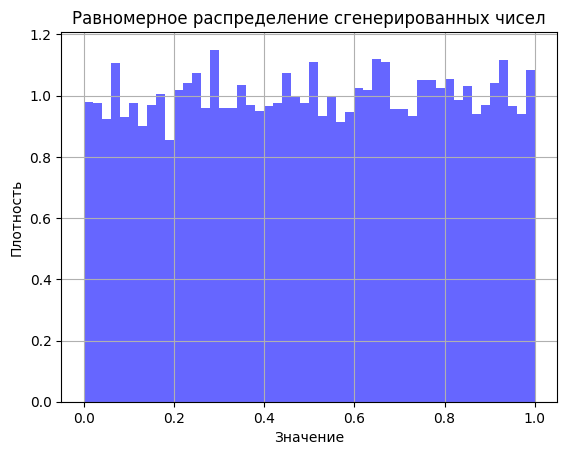

In [1]:
import matplotlib.pyplot as plt
from MersenneTwister import MersenneTwister

mt = MersenneTwister()
n = 10000

random_floats = [mt.genrand_float() for _ in range(n)]

plt.hist(random_floats, bins=50, density=True, alpha=0.6, color='b')
plt.title('Равномерное распределение сгенерированных чисел')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()


<h3>Генератор других распределений</h3>

In [2]:
from DistributionSampler import DistributionSampler
import numpy as np

mt = MersenneTwister()
sampler = DistributionSampler(mt)

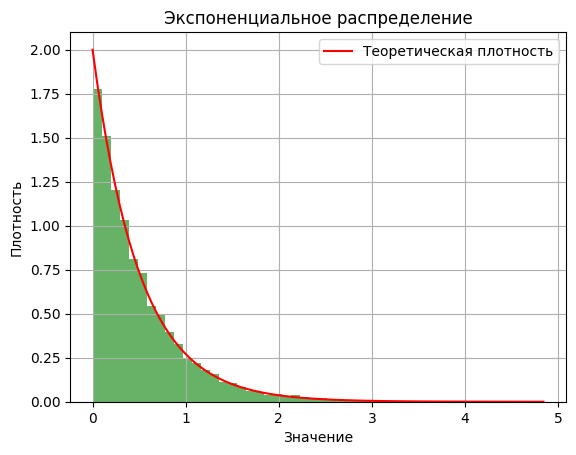

In [3]:
lambd = 2
exp_samples = [sampler.exponential(lambd) for _ in range(10000)]

plt.hist(exp_samples, bins=50, density=True, alpha=0.6, color='g')
x = np.linspace(0, max(exp_samples), 100)
plt.plot(x, lambd * np.exp(-lambd * x), 'r', label="Теоретическая плотность")
plt.legend()
plt.title("Экспоненциальное распределение")
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.grid(True)
plt.show()

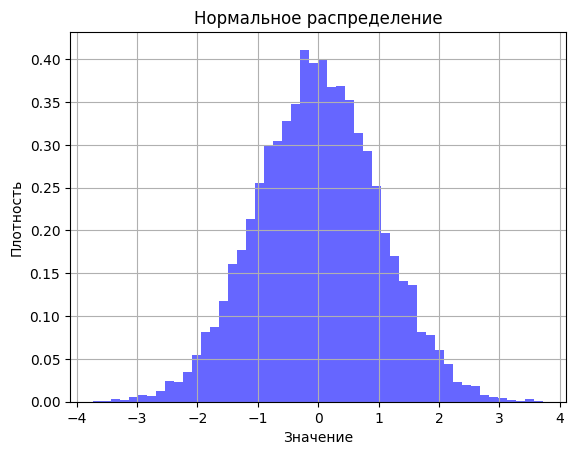

In [4]:
normal_samples = [sampler.normal() for _ in range(10000)]

plt.hist(normal_samples, bins=50, density=True, alpha=0.6, color='b')
x = np.linspace(-4, 4, 100)
plt.title("Нормальное распределение")
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.grid(True)
plt.show()

<h2>Симуляция</h2>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv
from collections import deque
import heapq
import random
from DistributionSampler import DistributionSampler
from MersenneTwister import MersenneTwister
from models.Library import Library
from models.Librarian import Librarian
from models.User import User

def simulate_library(num_books=3, copies_per_book=2, num_librarians=2, num_users=12, arrival_rate=1/5, librarian_mean=2, librarian_std=0.5, user_mean=30, user_std=5):
    generator = MersenneTwister()
    sampler = DistributionSampler(generator)
    library = Library(num_books=num_books, copies_per_book=copies_per_book, num_librarians=num_librarians, generator=generator, normal_mean_librarian=librarian_mean, normal_std_librarian=librarian_std)
    users = [User(i, generator, normal_mean=user_mean, normal_std=user_std) for i in range(num_users)]
    events = []
    current_time = 0

    for user in users:
        book_name = f"Book_{random.randint(0, num_books - 1)}"
        current_time += sampler.exponential(arrival_rate)
        event_time, success = library.request_book(user, book_name, current_time)
        if success:
            reading_time = user.decide_reading_time()
            heapq.heappush(events, (event_time + reading_time, user, book_name))
    
    while events:
        event_time, user, book_name = heapq.heappop(events)
        new_time, next_user = library.return_book(user, book_name, event_time)
        if next_user:
            reading_time = next_user.decide_reading_time()
            heapq.heappush(events, (new_time + reading_time, next_user, book_name))
    
    avg_wait_time = sum(library.wait_times) / len(library.wait_times)
    avg_librarian_workload = sum(l.total_service_time for l in library.librarians) / len(library.librarians)

    return avg_wait_time, library.served_users, avg_librarian_workload, current_time

avg_wait_time, served_users, avg_librarian_workload, overall_simulation_time = simulate_library()

print(f"Среднее время ожидания: {avg_wait_time:.2f} минут")
print(f"Количество обслуженных клиентов за минуту: {overall_simulation_time / served_users}")
print(f"Среднее время работы библиотекарей: {avg_librarian_workload:.2f} минут")

Среднее время ожидания: 22.53 минут
Количество обслуженных клиентов за минуту: 5.206895119995961
Среднее время работы библиотекарей: 24.17 минут


In [16]:
import time

start_time = time.time()
N = 1_000_000
results = []

params = {
    'num_books': 5,
    'copies_per_book': 3,
    'num_librarians': 3,
    'num_users': 20,
    'arrival_rate': 1/4,  # Среднее время прибытия пользователей
    'librarian_mean': 2,  # Среднее время обслуживания пользователем
    'librarian_std': 0.5,  # Стандартное отклонение для времени обслуживания библиотекарем
    'user_mean': 30,  # Среднее время чтения пользователем
    'user_std': 5  # Стандартное отклонение для времени чтения
}

for i in range(N):
    avg_wait_time, served_users, avg_librarian_workload, overall_simulation_time = simulate_library(**params)
    results.append((avg_wait_time, served_users, avg_librarian_workload, overall_simulation_time))
    if (i % 10000 == 0):
        print(i)

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")


0
10000


KeyboardInterrupt: 

<h2>Графики</h2>

In [ ]:
avg_wait_times = [result[0] for result in results]
served_users = [result[1] for result in results]
avg_librarian_workloads = [result[2] for result in results]
overall_sim_times = [result[3] for result in results]

served_users_per_minute = [users / (sim_time / 60) for users, sim_time in zip(served_users, overall_sim_times)]

mean_wait_time = np.mean(avg_wait_times)
mean_served_per_minute = np.mean(served_users_per_minute)
mean_librarian_workload = np.mean(avg_librarian_workloads)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))


axes[0].plot(avg_wait_times, color='blue', label="Время ожидания")
axes[0].axhline(mean_wait_time, color='red', linestyle="--", label=f"Среднее: {mean_wait_time:.2f}")
axes[0].set_title('Среднее время ожидания пользователей')
axes[0].set_xlabel('Итерации')
axes[0].set_ylabel('Время ожидания (сек.)')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(served_users_per_minute, color='green', label="Обслужено в минуту")
axes[1].axhline(mean_served_per_minute, color='red', linestyle="--", label=f"Среднее: {mean_served_per_minute:.2f}")
axes[1].set_title('Количество обслуженных пользователей в минуту')
axes[1].set_xlabel('Итерации')
axes[1].set_ylabel('Пользователей/мин')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(avg_librarian_workloads, color='orange', label="Загрузка библиотекарей")
axes[2].axhline(mean_librarian_workload, color='red', linestyle="--", label=f"Среднее: {mean_librarian_workload:.2f}")
axes[2].set_title('Средняя загрузка библиотекарей')
axes[2].set_xlabel('Итерации')
axes[2].set_ylabel('Средняя загрузка')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()